In [ ]:
import glob
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Вчитување податоци
Ќе работиме само со општините под Скопје.

In [ ]:
import os
import glob
import pandas as pd

csv_path = '/content/drive/MyDrive/datasets/'

# Читање на сите CSV фајлови од директориумот
csv_files = glob.glob(csv_path + "*.csv")

# Список за чување на датафрејмови
dataframes = []

# За PM2.5
file25_1 = "combined_report_Centar.csv"
file25_2 = "combined_report_Karpos.csv"

# Пронаоѓање на фајловите
csv_files25 = glob.glob(csv_path + file25_1) + glob.glob(csv_path + file25_2)

# Проверка дали фајловите се пронајдени
print("Found CSV files for PM2.5:", csv_files25)

if len(csv_files25) == 0:
    raise ValueError("No valid CSV files found for PM2.5 in the specified path.")

# Список за чување на податоци за PM2.5
dataframes25 = []

for file in csv_files25:
    df25 = pd.read_csv(file)
    dataframes25.append(df25)

# Проверка дали има податоци пред да ги споиме датафрејмовите
if len(dataframes25) == 0:
    raise ValueError("No data was loaded from PM2.5 CSV files. Check file paths or formats.")

# Спојување на сите датафрејмови во еден DataFrame
df25_combined = pd.concat(dataframes25, ignore_index=True)

# Претворање на времето во разбирлив формат
if 'time' in df25_combined.columns:
    df25_combined["time"] = pd.to_datetime(df25_combined["time"], unit='s')

data25 = df25_combined

# Итерирање низ сите фајлови за PM10
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Спојување на сите датафрејмови во еден
df_combined = pd.concat(dataframes, ignore_index=True)

# Претворање на времето во разбирлив формат (ако е во UNIX timestamp)
if 'time' in df_combined.columns:
    df_combined["time"] = pd.to_datetime(df_combined["time"], unit='s')

# Прикажување на првите неколку редови за проверка
print(df_combined.head())

# Зачувување во data
data = df_combined


Found CSV files for PM2.5: ['/content/drive/MyDrive/datasets/combined_report_Centar.csv', '/content/drive/MyDrive/datasets/combined_report_Karpos.csv']
   apparentTemperature  cloudCover  dewPoint  humidity         icon  ozone  \
0                11.77         1.0      7.85      0.55    clear-day  285.0   
1                17.37         1.0      7.85      0.48    clear-day  285.0   
2                16.02         1.0      8.89      0.51    clear-day  285.0   
3                13.46         1.0     10.52      0.58    clear-day  285.0   
4                 6.93         1.0      7.09      0.58  clear-night  285.0   

   precipAccumulation  precipIntensity  precipProbability precipType  ...  \
0              0.0024              0.0                0.0       snow  ...   
1              0.0024              0.0                0.0       snow  ...   
2              0.0024              0.0                0.0       snow  ...   
3              0.0024              0.0                0.0       snow  .

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114277 entries, 0 to 114276
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   apparentTemperature  114277 non-null  float64       
 1   cloudCover           114277 non-null  float64       
 2   dewPoint             114277 non-null  float64       
 3   humidity             114277 non-null  float64       
 4   icon                 114277 non-null  object        
 5   ozone                114277 non-null  float64       
 6   precipAccumulation   114277 non-null  float64       
 7   precipIntensity      114277 non-null  float64       
 8   precipProbability    114277 non-null  float64       
 9   precipType           114277 non-null  object        
 10  pressure             114277 non-null  float64       
 11  summary              114277 non-null  object        
 12  temperature          114277 non-null  float64       
 13  time          

Од Скопските општини, сите имаат достапни податоци за PM10. Целта на нашиот модел ќе биде предвидување на вредноста на PM10 честичките.

In [ ]:
data=data.drop(columns=['PM25','AQI'])

Се одлучивме да градиме модел и за оние општини кои имаат достапни податоци за PM 2.5, Центар и Гази Баба.

In [ ]:
data25 = data25.drop(columns=['PM10','AQI'])

# 2.Чистење на податоци


In [ ]:
columns_with_zeros = [col for col in data.columns if (data[col] == 0).any()]

zero_counts = {col: (data[col] == 0).sum() for col in columns_with_zeros}

zero_counts

{'cloudCover': 2170,
 'precipIntensity': 113175,
 'precipProbability': 113175,
 'uvIndex': 85031,
 'windBearing': 33173,
 'windGust': 53061,
 'windSpeed': 25905,
 'CO': 113,
 'NO2': 45,
 'O3': 21493,
 'PM10': 15,
 'SO2': 40698}

In [ ]:
columns_with_zeros25 = [col for col in data25.columns if (data25[col] == 0).any()]

zero_counts25 = {col: (data25[col] == 0).sum() for col in columns_with_zeros25}

zero_counts25

{'cloudCover': 968,
 'precipIntensity': 46203,
 'precipProbability': 46203,
 'uvIndex': 34558,
 'windBearing': 13401,
 'windGust': 35364,
 'windSpeed': 10889,
 'CO': 37,
 'NO2': 32,
 'O3': 7,
 'PM25': 10,
 'SO2': 40688}

* Таму кадешто имаме малку нули, ќе бидат исфрлени тие редици.



* Таму кадешто нулата е логична, на пример за precipIntensity, precipProbability вредност 0 е логична, (би значело нема детектирани врнежи нити пак има веројатност за врнежи), ја оставам.

* Сепак, во ситуации за:

SO2 вредноста не може да биде нула. Имено, SO₂ природно се ослободува во атмосферата преку вулканска активност, разградување на органски материјали и други природни процеси.
Дури и во оддалечени области без човечка активност, обично постојат траги од SO₂

О3 исто така не може да биде нула. Озонот се создава природно во атмосферата преку хемиски реакции меѓу сончевото зрачење и молекулите на кислород (O₂).Дури и во многу чисти области, далеку од индустриски и урбани региони, секогаш ќе има траги од озон поради природни процеси.

Во овие два конкретни случаи, ќе ја пресметаме вредноста на SO2, O3.

In [ ]:
data = data[~( (data['CO'] == 0) | (data['NO2'] == 0) | (data['PM10'] == 0) )]
data25=data25[~( (data25['CO'] == 0) | (data25['NO2'] == 0) | (data25['PM25'] == 0) )]

## 2.1 Пополнување на нулите од SO2, O3
Првичниот пристап ни беше
-пополни ги нулите преку KNN imputer, според features кои најмногу придонесуваат кон варијација на вредноста на SO2, O3, соодветно
-преостанатите нули пополни ги со средна вредност на колоната

Вториот пристап ни беше
-пополнување на нулите со средната вредност на колоните SO2, O3.
Истиот ни даде подобри резултати, па затоа го задржавме.

PM10

In [ ]:
# from sklearn.neighbors import NearestNeighbors
# import numpy as np

# # Step 4: Identify rows with missing or zero values for SO2 and O3
# rows_with_missing_so2 = data[(data['SO2'] == 0) | (data['SO2'].isna())]
# rows_with_missing_o3 = data[(data['O3'] == 0) | (data['O3'].isna())]

# # Step 5: Apply KNN to impute missing values
# knn_so2 = NearestNeighbors(n_neighbors=5)
# knn_o3 = NearestNeighbors(n_neighbors=5)

# # Fit KNN on the top features
# X_top_features_so2 = data[top_features_so2].reset_index(drop=True)  # Reset index to avoid mismatches
# X_top_features_o3 = data[top_features_o3].reset_index(drop=True)

# knn_so2.fit(X_top_features_so2)
# knn_o3.fit(X_top_features_o3)

# # Impute missing SO2 values
# for idx in rows_with_missing_so2.index:
#     try:
#         # Ensure the row data is properly formatted for kneighbors
#         row_data = X_top_features_so2.iloc[idx].values.reshape(1, -1)
#         distances, indices = knn_so2.kneighbors(row_data)
#         neighbor_values = data.iloc[indices[0]]['SO2']  # Use iloc for correct indexing
#         data.at[idx, 'SO2'] = neighbor_values.mean()  # Assign mean value of neighbors
#     except IndexError:
#         print(f"Index {idx} could not be processed. Skipping...")

# # Impute missing O3 values
# for idx in rows_with_missing_o3.index:
#     try:
#         # Ensure the row data is properly formatted for kneighbors
#         row_data = X_top_features_o3.iloc[idx].values.reshape(1, -1)
#         distances, indices = knn_o3.kneighbors(row_data)
#         neighbor_values = data.iloc[indices[0]]['O3']  # Use iloc for correct indexing
#         data.at[idx, 'O3'] = neighbor_values.mean()  # Assign mean value of neighbors
#     except IndexError:
#         print(f"Index {idx} could not be processed. Skipping...")


In [ ]:
columns_to_impute = ['SO2', 'O3']

# 1. Пресметај мин и макс за SO2 и O3
min_values = data[columns_to_impute].min()
max_values = data[columns_to_impute].max()

# 2. Пресметај стандардна девијација
std_dev = data[columns_to_impute].std()

# 3. Одлучи дали стандардната девијација е во разумни граници
acceptable_std_dev = (std_dev < (max_values - min_values) / 2)  # Емпирично правило

In [ ]:
print("Минимални вредности:")
print(min_values)

print("Максимални вредности:")
print(max_values)

print("Стандардна девијација:")
print(std_dev)

Минимални вредности:
SO2   -0.98
O3    -0.98
dtype: float64
Максимални вредности:
SO2    139370.90
O3        140.89
dtype: float64
Стандардна девијација:
SO2    412.613916
O3      30.735381
dtype: float64


In [ ]:
import numpy as np

data[columns_to_impute] = data[columns_to_impute].replace(0, np.nan)

# Пресметај средна вредност само за колоните што ги обработуваме
mean_values = data[columns_to_impute].mean()

# Пополни само тие колони со нивната средна вредност
data[columns_to_impute] = data[columns_to_impute].fillna(mean_values)

print("Нулите во колоните", columns_to_impute, "се пополнети со средната вредност.")

Нулите во колоните ['SO2', 'O3'] се пополнети со средната вредност.


<ipython-input-12-4089e54ff34e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_impute] = data[columns_to_impute].replace(0, np.nan)
<ipython-input-12-4089e54ff34e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_impute] = data[columns_to_impute].fillna(mean_values)


PM 2.5

In [ ]:
#from sklearn.neighbors import NearestNeighbors
#import numpy as np

# Step 4: Identify rows with missing or zero values for SO2 and O3
#rows_with_missing_so2 = data25[(data25['SO2'] == 0) | (data25['SO2'].isna())]
#rows_with_missing_o3 = data25[(data25['O3'] == 0) | (data25['O3'].isna())]

# Step 5: Apply KNN to impute missing values
#knn_so2 = NearestNeighbors(n_neighbors=5)
#knn_o3 = NearestNeighbors(n_neighbors=5)

# Fit KNN on the top features
#X_top_features_so2 = data25[top_features_so2].reset_index(drop=True)  # Reset index to avoid mismatches
#X_top_features_o3 = data25[top_features_o3].reset_index(drop=True)

#knn_so2.fit(X_top_features_so2)
#knn_o3.fit(X_top_features_o3)

# Impute missing SO2 values
#for idx in rows_with_missing_so2.index:
 #   try:
        # Ensure the row data is properly formatted for kneighbors
  #      row_data = X_top_features_so2.iloc[idx].values.reshape(1, -1)
   #     distances, indices = knn_so2.kneighbors(row_data)
    #    neighbor_values = data25.iloc[indices[0]]['SO2']  # Use iloc for correct indexing
     #   data25.at[idx, 'SO2'] = neighbor_values.mean()  # Assign mean value of neighbors
    #except IndexError:
     #   print(f"Index {idx} could not be processed. Skipping...")

# Impute missing O3 values
#for idx in rows_with_missing_o3.index:
 #   try:
        # Ensure the row data is properly formatted for kneighbors
  #      row_data = X_top_features_o3.iloc[idx].values.reshape(1, -1)
   #     distances, indices = knn_o3.kneighbors(row_data)
    #    neighbor_values = data25.iloc[indices[0]]['O3']  # Use iloc for correct indexing
     #   data25.at[idx, 'O3'] = neighbor_values.mean()  # Assign mean value of neighbors
    #except IndexError:
     #   print(f"Index {idx} could not be processed. Skipping...")

In [ ]:
columns_to_impute = ['SO2', 'O3']

# 1. Пресметај мин и макс за SO2 и O3
min_values = data25[columns_to_impute].min()
max_values = data25[columns_to_impute].max()

# 2. Пресметај стандардна девијација
std_dev = data25[columns_to_impute].std()

# 3. Одлучи дали стандардната девијација е во разумни граници
acceptable_std_dev25 = (std_dev < (max_values - min_values) / 2)  # Емпирично правило

In [ ]:
acceptable_std_dev25

,0
SO2,True
O3,True


In [ ]:
print("Минимални вредности:")
print(min_values)

print("Максимални вредности:")
print(max_values)

print("Стандардна девијација:")
print(std_dev)

Минимални вредности:
SO2    0.0
O3     0.0
dtype: float64
Максимални вредности:
SO2    139370.90
O3        140.89
dtype: float64
Стандардна девијација:
SO2    647.961558
O3      30.377265
dtype: float64


In [ ]:
data25[columns_to_impute] = data25[columns_to_impute].replace(0, np.nan)

# Пресметај средна вредност само за колоните што ги обработуваме
mean_values = data25[columns_to_impute].mean()

# Пополни само тие колони со нивната средна вредност
data25[columns_to_impute] = data25[columns_to_impute].fillna(mean_values)

print("Нулите во колоните", columns_to_impute, "се пополнети со средната вредност.")

Нулите во колоните ['SO2', 'O3'] се пополнети со средната вредност.


## 2.2 Пополнување на NaN преку К најблиски соседи
Најдовме дека колоната СО2 содржи NaN вредности кои произлегуваат од три од петте CSV фајлови што ги споивме: Карпош, Лисиче и Миладиновци. Овие три табели носат најголем дел од релевантните информации за нашите модели. Затоа, за да го зачуваме интегритетот на податоците и да избегнеме вештачко пополнување кое би можело да внесе пристрасност, одлучивме да ја отстраниме колоната СО2 наместо да ги импутираме нејзините недостасувачки вредности. Ова ни овозможува понатаму да примениме Feature Selection со Gradient Boosting без проблеми поврзани со недостасувачки податоци.

In [ ]:
print("Number of NaN values per column, for data10:")
print(data.isna().sum())

Number of NaN values per column, for data10:
apparentTemperature        0
cloudCover                 0
dewPoint                   0
humidity                   0
icon                       0
ozone                      0
precipAccumulation         0
precipIntensity            0
precipProbability          0
precipType                 0
pressure                   0
summary                    0
temperature                0
time                       0
uvIndex                    0
visibility                 0
windBearing                0
windGust                   0
windSpeed                  0
CO                         0
NO2                        0
O3                         0
PM10                       0
SO2                        0
CO2                    69278
dtype: int64


In [ ]:
print("Number of NaN values per column, for data25:")
print(data25.isna().sum())

Number of NaN values per column, for data25:
apparentTemperature        0
cloudCover                 0
dewPoint                   0
humidity                   0
icon                       0
ozone                      0
precipAccumulation         0
precipIntensity            0
precipProbability          0
precipType                 0
pressure                   0
summary                    0
temperature                0
time                       0
uvIndex                    0
visibility                 0
windBearing                0
windGust                   0
windSpeed                  0
CO                         0
NO2                        0
O3                         0
PM25                       0
SO2                        0
CO2                    23639
dtype: int64


In [ ]:
data=data.drop(columns=['CO2'])
data25=data25.drop(columns=['CO2'])

## 2.3 Објекти

Вредностите на колоните icon и summary претставуваат карактеристики кои не се директно измерени, туку се базирани на субјективна проценка на набљудувачот. Поради оваа причина, тие не ги сметаме за доволно релевантни за понатамошна анализа.

Од друга страна, сакаме да ја провериме важноста на precipType (дали врнежите се од дожд или снег) за да знаеме дали оваа карактеристика да ја задржиме (и енкодираме), или исфрлиме.

In [ ]:
data=data.drop(columns=['icon','summary'])
data25=data25.drop(columns=['icon','summary'])

In [ ]:
data=data.drop(columns=['precipType'])

In [ ]:
data25=data25.drop(columns=['precipType'])

## 2.4 Отстранување outliers

In [ ]:
def print_summary_stats(df, name):
    df_numeric = df.select_dtypes(include=["number"])
    summary = pd.DataFrame({
        'Min': df_numeric.min(),
        'Max': df_numeric.max(),
        'Mean': df_numeric.mean()
    })
    print(f"Summary statistics for {name}:")
    display(summary)

print_summary_stats(data, 'data')
print_summary_stats(data25, 'data25')


Summary statistics for data:


,Min,Max,Mean
apparentTemperature,-1.9100,105.2500,57.085579
cloudCover,0.0000,1.0000,0.682005
dewPoint,3.8600,69.8100,45.010240
humidity,0.0800,1.0000,0.668881
ozone,258.4000,336.7000,295.727158
precipAccumulation,0.0012,0.0115,0.002146
precipIntensity,0.0000,0.0167,0.000022
precipProbability,0.0000,0.1500,0.000920
pressure,1004.0000,1030.5900,1016.835175
temperature,8.0700,104.0400,57.633461


Summary statistics for data25:


,Min,Max,Mean
apparentTemperature,1.1400,105.2500,56.834096
cloudCover,0.0000,1.0000,0.728903
dewPoint,3.8600,69.8100,44.784740
humidity,0.0800,1.0000,0.667732
ozone,266.1000,336.7000,301.026482
precipAccumulation,0.0012,0.0049,0.001787
precipIntensity,0.0000,0.0051,0.000003
precipProbability,0.0000,0.1100,0.000138
pressure,1004.0900,1030.2300,1016.789002
temperature,8.3700,103.7800,57.379850


Од увиденото, генерално податоците имаат логична распределба на минималната и максималната вредност, но не може PM10 и PM2.5 да бидат негативни вредности.
Исто така, ни CO, NO2, O3 не можат да бидат под нула, па ги отстрануваме. Со сите outliers, ќе се справи IQR методата.

In [ ]:
def remove_negative_values(df, columns):
    for col in columns:
        df = df[df[col] >= 0]
    return df

data = remove_negative_values(data, ["CO", "NO2", "O3", "PM10"])
data25 = remove_negative_values(data25, ["CO", "NO2", "O3", "PM25"])

def print_summary_stats(df, name):
    summary = pd.DataFrame({
        'Min': df.min(),
        'Max': df.max(),
        'Mean': df.mean()
    })
    print(f"Summary statistics for {name}:")
    display(summary)


In [ ]:
import numpy as np

# Функција за детекција и отстранување на outliers користејќи IQR метод
def remove_outliers_iqr(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1

    # Ги отстранува вредностите што се над Q3 + 1.5 * IQR или под Q1 - 1.5 * IQR
    df = df[~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

    return df

# Примена на IQR методот за чистење на outliers
data = remove_outliers_iqr(data, ['PM10'])
data25 = remove_outliers_iqr(data25, ['PM25'])


## 2.5 Справување со времето
За да работиме со LSTMs/RNNs, форматот кој го имаме во моментов (пр. 2015-01-01 00:00:00), не е погоден, иако е добар за визуелизација. Затоа, треба да ги издвоиме важните карактеристики од времето како на пример:
-час, ден, месец, година
-ден од неделата
-дали е викенд или празник
...

Тоа дали е празник (неработен ден!) ќе го направиме такашто ќе ги најдеме сите неработни денови во временскиот опсег во кој се мерени податоците.

In [ ]:
import numpy as np

data['time'] = pd.to_datetime(data['time'], unit='s')

data['hour'] = data['time'].dt.hour
data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data['day_of_week'] = data['time'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data.head()

<ipython-input-27-79856807b084>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'] = pd.to_datetime(data['time'], unit='s')
<ipython-input-27-79856807b084>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hour'] = data['time'].dt.hour
<ipython-input-27-79856807b084>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,apparentTemperature,cloudCover,dewPoint,humidity,ozone,precipAccumulation,precipIntensity,precipProbability,pressure,temperature,...,hour,day,month,year,day_of_week,is_weekend,hour_sin,hour_cos,month_sin,month_cos
0,11.77,1.0,7.85,0.55,285.0,0.0024,0.0,0.0,1016.5,21.67,...,10,1,1,2015,3,0,0.500000,-0.866025,0.5,0.866025
1,17.37,1.0,7.85,0.48,285.0,0.0024,0.0,0.0,1016.5,24.67,...,11,1,1,2015,3,0,0.258819,-0.965926,0.5,0.866025
2,16.02,1.0,8.89,0.51,285.0,0.0024,0.0,0.0,1016.5,24.67,...,13,1,1,2015,3,0,-0.258819,-0.965926,0.5,0.866025
3,13.46,1.0,10.52,0.58,285.0,0.0024,0.0,0.0,1016.5,23.05,...,14,1,1,2015,3,0,-0.500000,-0.866025,0.5,0.866025
4,6.93,1.0,7.09,0.58,285.0,0.0024,0.0,0.0,1016.5,19.36,...,16,1,1,2015,3,0,-0.866025,-0.500000,0.5,0.866025


Податоците ни се мерени од 1.1.2015 до 30.12.2018, значи треба да ги најдам сите неработни денови во Македонија за 2015,2016,2017,2018.

In [ ]:
macedonia_holidays = [
    # 2015
    '2015-01-01', '2015-01-07', '2015-04-13', '2015-05-01', '2015-05-24',
    '2015-07-17', '2015-08-02', '2015-09-08', '2015-10-11', '2015-10-23', '2015-12-08',
    # 2016
    '2016-01-01', '2016-01-07', '2016-05-01', '2016-05-02', '2016-05-24',
    '2016-07-05', '2016-08-02', '2016-09-08', '2016-10-11', '2016-10-23', '2016-12-08',
    # 2017
    '2017-01-01', '2017-01-02', '2017-01-07', '2017-04-17', '2017-05-01',
    '2017-05-24', '2017-06-25', '2017-08-02', '2017-09-08', '2017-10-11', '2017-10-23', '2017-12-08',
    # 2018
    '2018-01-01', '2018-01-07', '2018-01-08', '2018-04-09', '2018-05-01',
    '2018-05-24', '2018-06-15', '2018-08-02', '2018-09-08', '2018-10-11', '2018-10-23', '2018-12-08'
]

macedonia_holidays = pd.to_datetime(macedonia_holidays)

data['is_holiday'] = data['time'].dt.date.isin(macedonia_holidays.date).astype(int)

Откако од колоната time ги имаме извлечено сите карактеристики кои сметаме дека се потребни, можеме да ја исфрлиме.

In [ ]:
data=data.drop(columns=['time'])

И за PM2.5.


In [ ]:
data25['time'] = pd.to_datetime(data25['time'], unit='s')


data25['hour'] = data25['time'].dt.hour
data25['day'] = data25['time'].dt.day
data25['month'] = data25['time'].dt.month
data25['year'] = data25['time'].dt.year
data25['day_of_week'] = data25['time'].dt.dayofweek
data25['is_weekend'] = data25['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


data25['hour_sin'] = np.sin(2 * np.pi * data25['hour'] / 24)
data25['hour_cos'] = np.cos(2 * np.pi * data25['hour'] / 24)
data25['month_sin'] = np.sin(2 * np.pi * data25['month'] / 12)
data25['month_cos'] = np.cos(2 * np.pi * data25['month'] / 12)\

data25['is_holiday'] = data25['time'].dt.date.isin(macedonia_holidays.date).astype(int)

In [ ]:
data25=data25.drop(columns=['time'])

Сакаме да провериме дали на правилен начин сме се справиле со времето, и карактеристиките кои произлегуваат од него.

In [ ]:
print("Hour:", data["hour"].min(), "-", data["hour"].max())
print("Day:", data["day"].min(), "-", data["day"].max())
print("Month:", data["month"].min(), "-", data["month"].max())
print("Day of the Week:", data["day_of_week"].min(), "-", data["day_of_week"].max())
print("Is Weekend:", data["is_weekend"].unique())
print("Is Holiday:", data["is_holiday"].unique())


Hour: 0 - 23
Day: 1 - 31
Month: 1 - 12
Day of the Week: 0 - 6
Is Weekend: [0 1]
Is Holiday: [1 0]


# 3.Feature Selection


In [ ]:
data.shape

(102842, 31)

In [ ]:
data25.shape

(41719, 31)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression

target_pm25 = 'PM25'
target_pm10 = 'PM10'

X_pm25 = data25.drop(columns=[target_pm25])
y_pm25 = data25[target_pm25]

X_pm10 = data.drop(columns=[target_pm10])
y_pm10 = data[target_pm10]

def feature_selection_pipeline(X_train, y_train, top_k=25, corr_threshold=0.9, n_splits=5):
    """
    Uses Time Series Split for feature selection:
    - Gradient Boosting Feature Importance with TSS
    - SelectKBest (Univariate Analysis) with TSS
    - Removes highly correlated features
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    feature_importances = np.zeros(X_train.shape[1])

    for train_idx, val_idx in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = GradientBoostingRegressor(random_state=42)
        model.fit(X_train_fold, y_train_fold)
        feature_importances += model.feature_importances_

    feature_importances /= n_splits

    top_features = np.argsort(feature_importances)[::-1][:top_k]
    top_feature_names = X_train.columns[top_features]

    selected_features = []
    for train_idx, val_idx in tscv.split(X_train[top_feature_names]):
        X_train_fold, y_train_fold = X_train.iloc[train_idx][top_feature_names], y_train.iloc[train_idx]

        selector = SelectKBest(score_func=f_regression, k=min(top_k, X_train.shape[1]))
        selector.fit(X_train_fold, y_train_fold)
        selected_features.append(set(top_feature_names[selector.get_support()]))

    final_selected_features = list(set.intersection(*selected_features))

    corr_matrix = X_train[final_selected_features].corr()
    high_corr_features = set()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > corr_threshold:
                high_corr_features.add(corr_matrix.columns[i])

    final_features = [f for f in final_selected_features if f not in high_corr_features]

    return final_features

final_features_pm25 = feature_selection_pipeline(X_pm25, y_pm25)
final_features_pm10 = feature_selection_pipeline(X_pm10, y_pm10)

print("Final Selected Features for PM2.5:", final_features_pm25)
print("Final Selected Features for PM10:", final_features_pm10)

Final Selected Features for PM2.5: ['ozone', 'pressure', 'year', 'visibility', 'dewPoint', 'cloudCover', 'day', 'SO2', 'hour_sin', 'windBearing', 'month_sin', 'temperature', 'day_of_week', 'month_cos', 'uvIndex', 'month', 'humidity', 'hour_cos', 'CO', 'hour', 'NO2', 'O3', 'windSpeed']
Final Selected Features for PM10: ['ozone', 'pressure', 'year', 'visibility', 'day', 'cloudCover', 'precipAccumulation', 'dewPoint', 'SO2', 'hour_sin', 'month_sin', 'windBearing', 'temperature', 'windGust', 'month_cos', 'uvIndex', 'month', 'hour_cos', 'humidity', 'CO', 'hour', 'NO2', 'O3', 'windSpeed']


# 4.Модели - RNN

In [ ]:
print(data.columns)

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'ozone',
       'precipAccumulation', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'uvIndex', 'visibility', 'windBearing',
       'windGust', 'windSpeed', 'CO', 'NO2', 'O3', 'PM10', 'SO2', 'hour',
       'day', 'month', 'year', 'day_of_week', 'is_weekend', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'is_holiday'],
      dtype='object')


In [ ]:
print(data.isnull().sum())

apparentTemperature    0
cloudCover             0
dewPoint               0
humidity               0
ozone                  0
precipAccumulation     0
precipIntensity        0
precipProbability      0
pressure               0
temperature            0
uvIndex                0
visibility             0
windBearing            0
windGust               0
windSpeed              0
CO                     0
NO2                    0
O3                     0
PM10                   0
SO2                    0
hour                   0
day                    0
month                  0
year                   0
day_of_week            0
is_weekend             0
hour_sin               0
hour_cos               0
month_sin              0
month_cos              0
is_holiday             0
dtype: int64


## 4.1 Регресори

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

target_pm25 = 'PM25'
target_pm10 = 'PM10'

X_train_pm25 = X_pm25
y_train_pm25 = y_pm25
X_test_pm25 = X_pm25
y_test_pm25 = y_pm25

X_train_pm10 = X_pm10
y_train_pm10 = y_pm10
X_test_pm10 = X_pm10
y_test_pm10 = y_pm10

def train_and_evaluate_tss(model, X_train, y_train, X_test, y_test, final_features, model_name, n_splits=5):
    """Uses Time Series Split (TSS) for validation."""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    test_maes = []

    for train_idx, val_idx in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold[final_features], y_train_fold)
        val_pred = model.predict(X_val_fold[final_features])
        val_mae = mean_absolute_error(y_val_fold, val_pred)
        test_maes.append(val_mae)

    avg_mae = np.mean(test_maes)
    print(f"Avg Test MAE for {model_name}: {avg_mae}")
    return avg_mae


models = {
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42)
}

print("\nEvaluating Models for PM2.5 using Time Series Split:")
for model_name, model in models.items():
    train_and_evaluate_tss(model, X_train_pm25, y_train_pm25, X_test_pm25, y_test_pm25, final_features_pm25, model_name)

print("\nEvaluating Models for PM10 using Time Series Split:")
for model_name, model in models.items():
    train_and_evaluate_tss(model, X_train_pm10, y_train_pm10, X_test_pm10, y_test_pm10, final_features_pm10, model_name)


Evaluating Models for PM2.5 using Time Series Split:
Avg Test MAE for DecisionTreeRegressor: 12.916017808140372
Avg Test MAE for ExtraTreesRegressor: 10.032796772961312
Avg Test MAE for RandomForestRegressor: 9.78535244104703
Avg Test MAE for XGBRegressor: 9.953485061232644
Avg Test MAE for GradientBoostingRegressor: 9.569072868316278

Evaluating Models for PM10 using Time Series Split:
Avg Test MAE for DecisionTreeRegressor: 20.19023085414236
Avg Test MAE for ExtraTreesRegressor: 14.962792521376898
Avg Test MAE for RandomForestRegressor: 15.72827259227538
Avg Test MAE for XGBRegressor: 15.757564575049306
Avg Test MAE for GradientBoostingRegressor: 15.565652268123026


<ipython-input-38-834e3464e4e8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=models, x=scores, palette="coolwarm", edgecolor='black', linewidth=1.5)


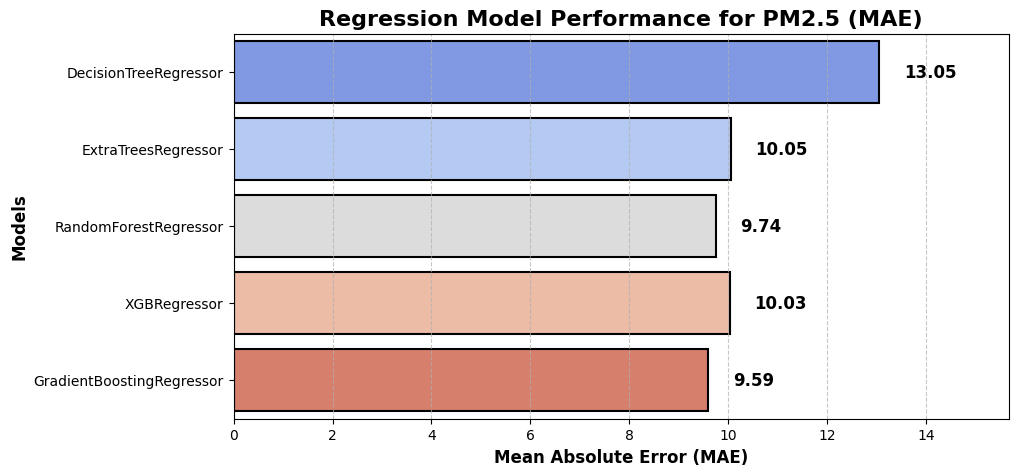

<ipython-input-38-834e3464e4e8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=models, x=scores, palette="coolwarm", edgecolor='black', linewidth=1.5)


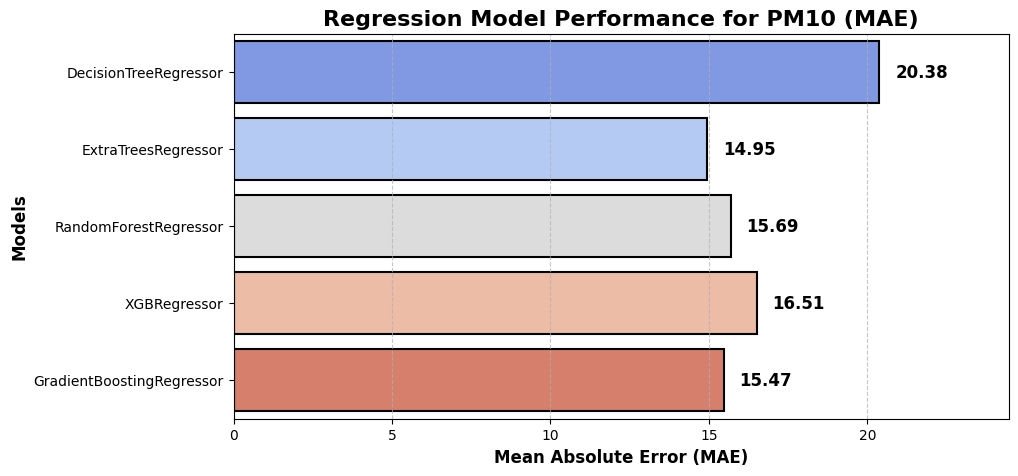

In [ ]:
def plot_mae_horizontal(results, title):
    models = list(results.keys())
    scores = list(results.values())

    plt.figure(figsize=(10, 5))
    sns.barplot(y=models, x=scores, palette="coolwarm", edgecolor='black', linewidth=1.5)

    plt.xlabel("Mean Absolute Error (MAE)", fontsize=12, fontweight='bold')
    plt.ylabel("Models", fontsize=12, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')

    for i, score in enumerate(scores):
        plt.text(score + 0.5, i, f"{score:.2f}", va='center', fontsize=12, fontweight='bold', color='black')

    plt.xlim(0, max(scores) * 1.2)  # Остави простор на десната страна за бројките
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Податоци за PM2.5 и PM10
results_pm25 = {
    "DecisionTreeRegressor": 13.05,
    "ExtraTreesRegressor": 10.05,
    "RandomForestRegressor": 9.74,
    "XGBRegressor": 10.03,
    "GradientBoostingRegressor": 9.59
}

results_pm10 = {
    "DecisionTreeRegressor": 20.38,
    "ExtraTreesRegressor": 14.95,
    "RandomForestRegressor": 15.69,
    "XGBRegressor": 16.51,
    "GradientBoostingRegressor": 15.47
}

# Прикажување на графиците за PM2.5 и PM10
plot_mae_horizontal(results_pm25, "Regression Model Performance for PM2.5 (MAE)")
plot_mae_horizontal(results_pm10, "Regression Model Performance for PM10 (MAE)")



In [ ]:
data.shape

(102842, 31)

In [ ]:
data25.shape

(41719, 31)

## 4.2 LSTM

In [ ]:
print(data.columns)

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'ozone',
       'precipAccumulation', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'uvIndex', 'visibility', 'windBearing',
       'windGust', 'windSpeed', 'CO', 'NO2', 'O3', 'PM10', 'SO2', 'hour',
       'day', 'month', 'year', 'day_of_week', 'is_weekend', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'is_holiday'],
      dtype='object')


PM2.5

In [ ]:
print(data25.shape)

(41719, 31)


In [ ]:
print(data.columns)

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'ozone',
       'precipAccumulation', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'uvIndex', 'visibility', 'windBearing',
       'windGust', 'windSpeed', 'CO', 'NO2', 'O3', 'PM10', 'SO2', 'hour',
       'day', 'month', 'year', 'day_of_week', 'is_weekend', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'is_holiday'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

# ✅ Load & Prepare Data
# Assuming `data` is a Pandas DataFrame already loaded

target = 'PM25'
features = data25.drop(columns=[target])
target_values = data25[target].values.reshape(-1, 1)  # Reshape for scaler

# ✅ Standardize Input Features
scaler_features = StandardScaler()
scaled_features = scaler_features.fit_transform(features)

# ✅ Standardize Target Variable
scaler_target = StandardScaler()
scaled_target = scaler_target.fit_transform(target_values)  # Scaling target

# ✅ Function to Create Sequences for LSTM
def create_sequences(data25, target, timesteps=48):  # Increased timesteps from 24 to 48
    X, y = [], []
    for i in range(len(data25) - timesteps):
        X.append(data25[i:i+timesteps])
        y.append(target[i+timesteps])
    return np.array(X), np.array(y)

timesteps = 48  # Increased from 24 for better pattern recognition
X, y = create_sequences(scaled_features, scaled_target, timesteps)

# ✅ Train-Test Split (No Shuffle to Preserve Time Dependency)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# ✅ Improved Model: CNN + LSTM Hybrid
model25 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(timesteps, X_train.shape[2])),
    MaxPooling1D(pool_size=2),

    LSTM(256, return_sequences=True),
    Dropout(0.3),

    LSTM(128, return_sequences=True),
    Dropout(0.2),

    LSTM(64),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output Layer
])

# ✅ Compile Model Using Huber Loss for Robustness
model25.compile(optimizer=Adam(learning_rate=0.0005), loss=MeanAbsoluteError(), metrics=['mae'])
model25.build(input_shape=(None, timesteps, X_train.shape[2]))

model25.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 48, 64)              │           5,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 24, 256)             │         328,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 24, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 587,329 (2.24 MB)

 Trainable params: 587,329 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class PrintCorrectedMAE(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(X_test, verbose=0)
        y_pred_original = scaler_target.inverse_transform(y_pred)
        y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

        mae_original = mean_absolute_error(y_test_original, y_pred_original)
        print(f"\n✅ Epoch {epoch+1}: Corrected MAE (Original Scale) = {mae_original:.4f}")

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint("best_model_PM25.h5", monitor="val_loss", save_best_only=True, mode="min")
print_mae_callback = PrintCorrectedMAE()
history = model25.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=70,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, print_mae_callback],
    verbose=1
)

test_loss, test_mae = model25.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Loss (Standardized Scale): {test_loss}")
print(f"✅ Test MAE (Standardized Scale): {test_mae}")

y_pred = model25.predict(X_test)
y_pred_original = scaler_target.inverse_transform(y_pred)
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

mae_original = mean_absolute_error(y_test_original, y_pred_original)
print(f"\n✅ Final Corrected Test MAE (Original Scale): {mae_original}")


Epoch 1/70
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.6609 - mae: 0.6609


✅ Epoch 1: Corrected MAE (Original Scale) = 9.3903
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 209s 193ms/step - loss: 0.6608 - mae: 0.6608 - val_loss: 0.7422 - val_mae: 0.7422 - learning_rate: 5.0000e-04
Epoch 2/70
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.5464 - mae: 0.5464


✅ Epoch 2: Corrected MAE (Original Scale) = 9.0232
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 207s 198ms/step - loss: 0.5464 - mae: 0.5464 - val_loss: 0.7132 - val_mae: 0.7132 - learning_rate: 5.0000e-04
Epoch 3/70
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.4874 - mae: 0.4874


✅ Epoch 3: Corrected MAE (Original Scale) = 8.6852
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 263s 200ms/step - loss: 0.4874 - mae: 0.4874 - val_loss: 0.6865 - val_mae: 0.6865 - learning_rate: 5.0000e-04
Epoch 4/70
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.4322 - mae: 0.4322


✅ Epoch 4: Corrected MAE (Original Scale) = 8.5188
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 263s 201ms/step - loss: 0.4322 - mae: 0.4322 - val_loss: 0.6733 - val_mae: 0.6733 - learning_rate: 5.0000e-04
Epoch 5/70
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.4024 - mae: 0.4024


✅ Epoch 5: Corrected MAE (Original Scale) = 8.4321
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 252s 191ms/step - loss: 0.4024 - mae: 0.4024 - val_loss: 0.6665 - val_mae: 0.6665 - learning_rate: 5.0000e-04
Epoch 6/70
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.3804 - mae: 0.3804
✅ Epoch 6: Corrected MAE (Original Scale) = 8.5607
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 201s 190ms/step - loss: 0.3804 - mae: 0.3804 - val_loss: 0.6767 - val_mae: 0.6767 - learning_rate: 5.0000e-04
Epoch 7/70
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.3535 - mae: 0.3535
✅ Epoch 7: Corrected MAE (Original Scale) = 8.9702
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 201s 189ms/step - loss: 0.3535 - mae: 0.3535 - val_loss: 0.7090 - val_mae: 0.7090 - learning_rate: 5.0000e-04
Epoch 8/70
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.3374 - mae: 0.3374
✅ Epoch 8: Corrected MAE (Original Scale) = 8.7196
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 202s 190ms/step - loss: 0.3374 - mae: 0.3374 - val_loss: 0.6892 - val_mae: 0.6892 - le

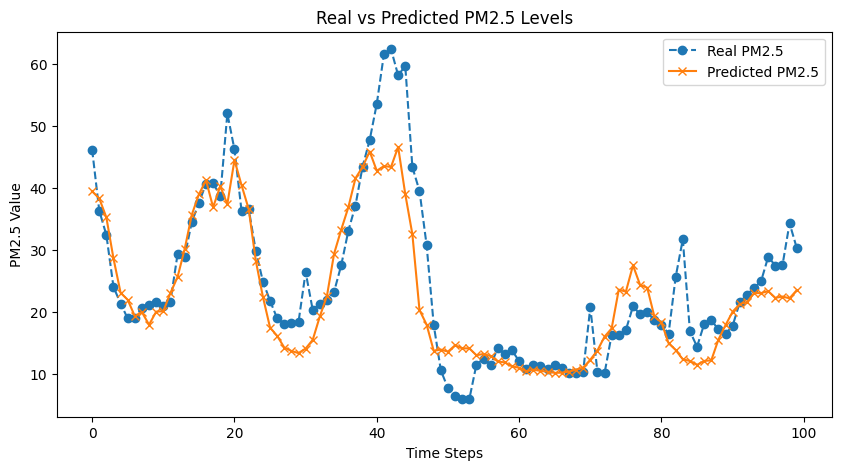

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_original[:100], label="Real PM2.5", marker="o", linestyle="dashed")
plt.plot(y_pred_original[:100], label="Predicted PM2.5", marker="x")
plt.legend()
plt.title("Real vs Predicted PM2.5 Levels")
plt.xlabel("Time Steps")
plt.ylabel("PM2.5 Value")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

data = data.reset_index(drop=True)
target = 'PM10'

features = data.drop(columns=[target])
target_values = data[target].values.reshape(-1, 1)

scaler_features = StandardScaler()
scaled_features = scaler_features.fit_transform(features)

scaler_target = StandardScaler()
scaled_target = scaler_target.fit_transform(target_values)

def create_sequences(data, target, timesteps=48):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(target[i+timesteps])
    return np.array(X), np.array(y)

timesteps = 48
X, y = create_sequences(scaled_features, scaled_target, timesteps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

model10 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(timesteps, X_train.shape[2])),
    MaxPooling1D(pool_size=2),

    LSTM(256, return_sequences=True),
    Dropout(0.3),

    LSTM(128, return_sequences=True),
    Dropout(0.2),

    LSTM(64),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model10.compile(optimizer=Adam(learning_rate=0.0005), loss=MeanAbsoluteError(), metrics=['mae'])
model10.build(input_shape=(None, timesteps, X_train.shape[2]))

model10.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 48, 64)              │           5,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 24, 256)             │         328,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 24, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 587,329 (2.24 MB)

 Trainable params: 587,329 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class PrintCorrectedMAE(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(X_test, verbose=0)
        y_pred_original = scaler_target.inverse_transform(y_pred)
        y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

        mae_original = mean_absolute_error(y_test_original, y_pred_original)
        print(f"\n✅ Epoch {epoch+1}: Corrected MAE (Original Scale) = {mae_original:.4f}")


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, mode="min")
print_mae_callback = PrintCorrectedMAE()

history = model10.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=70,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, print_mae_callback],
    verbose=1
)

test_loss, test_mae = model10.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Loss (Standardized Scale): {test_loss}")
print(f"✅ Test MAE (Standardized Scale): {test_mae}")

y_pred = model10.predict(X_test)
y_pred_original = scaler_target.inverse_transform(y_pred)
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

mae_original = mean_absolute_error(y_test_original, y_pred_original)
print(f"\n✅ Final Corrected Test MAE (Original Scale): {mae_original}")


Epoch 1/70
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.6574 - mae: 0.6574


✅ Epoch 1: Corrected MAE (Original Scale) = 12.1567
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 507s 195ms/step - loss: 0.6574 - mae: 0.6574 - val_loss: 0.5532 - val_mae: 0.5532 - learning_rate: 5.0000e-04
Epoch 2/70
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.5326 - mae: 0.5326
✅ Epoch 2: Corrected MAE (Original Scale) = 12.4246
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 504s 196ms/step - loss: 0.5326 - mae: 0.5326 - val_loss: 0.5654 - val_mae: 0.5654 - learning_rate: 5.0000e-04
Epoch 3/70
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.4842 - mae: 0.4842
✅ Epoch 3: Corrected MAE (Original Scale) = 12.5014
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 547s 190ms/step - loss: 0.4842 - mae: 0.4842 - val_loss: 0.5689 - val_mae: 0.5689 - learning_rate: 5.0000e-04
Epoch 4/70
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.4505 - mae: 0.4505
✅ Epoch 4: Corrected MAE (Original Scale) = 12.1613
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 507s 192ms/step - loss: 0.4505 - mae: 0.4505 - val_loss: 0.5534 - val_mae: 0.5534 

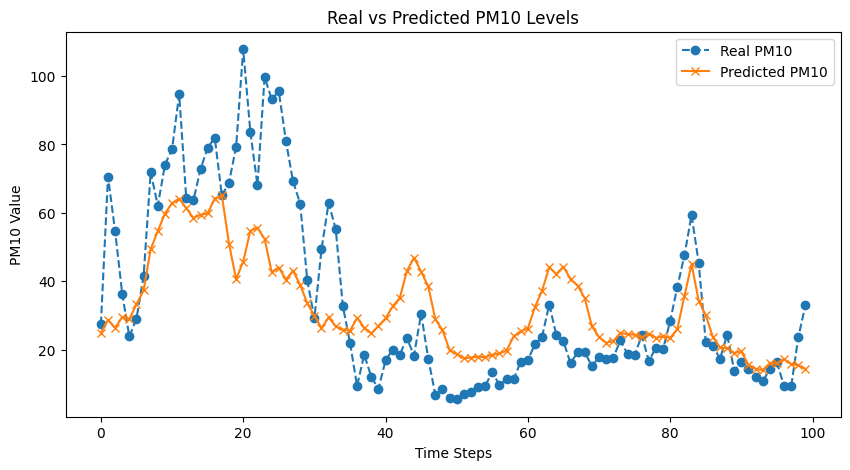

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_original[:100], label="Real PM10", marker="o", linestyle="dashed")
plt.plot(y_pred_original[:100], label="Predicted PM10", marker="x")
plt.legend()
plt.title("Real vs Predicted PM10 Levels")
plt.xlabel("Time Steps")
plt.ylabel("PM10 Value")
plt.show()